In [1]:
#| export
import numpy as np
import h5py
import pandas as pd
from typing import Dict
from secrets import token_hex
from pathlib import Path
from scipy import stats
import pyfstat
import matplotlib.pyplot as plt
import os
import random
from joblib import Parallel, delayed
from tqdm import tqdm
#%matplotlib inline

22-11-07 02:35:44.386 pyfstat INFO    : Running PyFstat version 1.18.1
22-11-07 02:35:44.481 pyfstat.utils.importing INFO    : No $DISPLAY environment variable found, so importing matplotlib.pyplot with non-interactive 'Agg' backend.


In [2]:



# | export
def read_file(filename):
    file_id = Path(filename).stem
    img = np.empty((2, 360, 128), dtype=np.float32)
    with h5py.File(filename, "r") as f:
        g = f[file_id]

        for ch, s in enumerate(["H1", "L1"]):
            a = g[s]["SFTs"][:, :4096] * 1e22  # Fourier coefficient complex64
            p = a.real**2 + a.imag**2  # power
            print(p.shape)
            p /= np.mean(p)  # normalize
            p = np.mean(p.reshape(360, 128, 32), axis=2)  # compress 4096 -> 128
            img[ch] = p
    return img


def read_timestemp(filename):
    file_id = Path(filename).stem
    img = dict()
    with h5py.File(filename, "r") as f:
        img["L1"] = np.copy(f[file_id]["L1"]["timestamps_GPS"])
        img["H1"] = np.copy(f[file_id]["H1"]["timestamps_GPS"])
    return img


def get_random_name(len_k=16):
    token = token_hex(len_k)
    return token


def save_hdf(
    name: str,
    sft_h1: np.array,
    sft_l1: np.array,
    timestamps: Dict,
    frequency: np.array,
    meta_: dict,
):
    hf = h5py.File(f"{name}.h5", "w")
    g1 = hf.create_group(name.stem)
    h1 = g1.create_group("H1")
    h1.create_dataset("SFTs", data=sft_h1)
    h1.create_dataset("timestamps_GPS", data=timestamps["H1"])

    l1 = g1.create_group("L1")
    l1.create_dataset("SFTs", data=sft_l1)
    l1.create_dataset("timestamps_GPS", data=timestamps["L1"])

    hf.create_dataset("frequency_Hz", data=frequency)
    pd.DataFrame(meta_).to_csv(f"{name}.csv", index=False)

    
import random

def constrained_sum_sample_pos(n, total):
    """Return a randomly chosen list of n positive integers summing to total.
    Each such list is equally likely to occur."""

    dividers = sorted(random.sample(range(1, total), n - 1))
    return [a - b for a, b in zip(dividers + [total], [0] + dividers)]

def get_random_sqrtx_noise():
    sqrtx_choice = [
        (2e-23, 2.5e-23),
        (1e-23, 1.5e-23),
        (3e-23, 3.5e-23),
        (4e-23, 4.5e-23),
        (5e-23, 5.5e-23),
        (6e-23, 7e-23),
    ]
    ch = random.choice(sqrtx_choice)
    return ch[0], ch[1]
    #return np.random.uniform(1e-23, 5e-23)

In [3]:
#def generate_data_v12(fn, save_folder, neg=False):
#    """
#    this function generates random data fragments using uniform values of sqrtSX for each segment
#    currently it usses narrow noise
#    """
#    # Generate signals with parameters drawn from a specific population
#    sft_path_h1 = []
#    sft_path_l1 = []
#    # These parameters describe background noise and data format
#    m = 10#np.random.randint(20, 70)
#    segment_lengths = list(np.array(constrained_sum_sample_pos(m, 86 * 2)) * 43200)
#    ch_0, ch_1 = get_random_sqrtx_noise()
#    segment_sqrtSX = [np.random.uniform(ch_0, ch_1) for i in range(m)]
#
#    writer_kwargs = {
#        "tstart": 1238166018,
#        "detectors": "H1",
#        "Tsft": 1800,
#        "SFTWindowType": "tukey",
#        "SFTWindowBeta": random.choice([0.01, 0.001]),
#        "Band": 0.2,
#    }
#
#    h_0 = lambda: random.choice(segment_sqrtSX) / stats.uniform(1, 50).rvs()
#    if neg:
#        h_0 = 0
#    signal_parameters_generator = pyfstat.AllSkyInjectionParametersGenerator(
#        priors={
#            "tref": writer_kwargs["tstart"],
#            "F0": {"uniform": {"low": 50, "high": 500}},
#            "F1": lambda: 10 ** stats.uniform(-12, 4).rvs(),
#            "F2": 0,
#            "h0": h_0,
#            **pyfstat.injection_parameters.isotropic_amplitude_priors,
#        },
#    )
#
#    # Draw signal parameters.
#    # Noise can be drawn by setting `params["h0"] = 0
#    name = save_folder / f"hb_{fn}"
#    params = signal_parameters_generator.draw()
#    # same timestemps as in test data
#    # writer_kwargs['timestamps'] = get_random_timesteps(random.choice(t_fns))
#    for segment in range(len(segment_lengths)):
#        writer_kwargs["outdir"] = f"PyFstat_example_data_ensemble/Signal_{fn}"
#        writer_kwargs["label"] = f"Signal_{fn}"
#        writer_kwargs["duration"] = segment_lengths[segment]
#        writer_kwargs["sqrtSX"] = segment_sqrtSX[segment]
#
#        if segment > 0:
#            writer_kwargs["tstart"] += (
#                writer_kwargs["Tsft"] + segment_lengths[segment - 1]
#            )
#        
#        writer = pyfstat.LineWriter(**writer_kwargs, **params)
#        writer.make_data()
#        sft_path_h1.append(writer.sftfilepath)
#        
#        writer_kwargs['detectors'] = "L1"
#        writer = pyfstat.LineWriter(**writer_kwargs, **params)
#        writer.make_data()
#        sft_path_l1.append(writer.sftfilepath)
#
#    # SNR can be compute from a set of SFTs for a specific set
#    # of parameters as follows:
#    sft_path_h1 = ";".join(sft_path_h1)
#    sft_path_l1 = ";".join(sft_path_l1)
#    
#    snr = pyfstat.SignalToNoiseRatio.from_sfts(F0=writer.F0, sftfilepath=sft_path_h1)
#    squared_snr = snr.compute_snr2(
#        Alpha=writer.Alpha,
#        Delta=writer.Delta,
#        psi=writer.psi,
#        phi=writer.phi,
#        h0=writer.h0,
#        cosi=writer.cosi,
#    )
#
#    meta_ = {
#        "alpha": [writer.Alpha],
#        "daelta": [writer.Delta],
#        "cosi": [writer.cosi],
#        "psi": [writer.psi],
#        "phi": [writer.phi],
#        "h0": [writer.h0],
#        "f0": [writer.F0],
#        "f1": [writer.F1],
#        "snr": [np.sqrt(squared_snr)],
#    }
#    print(meta_)
#    # Data can be read as a numpy array using PyFstat
#    frequency, timestamps_h1, amplitudes = pyfstat.utils.get_sft_as_arrays(sft_path_h1)
#    sft_h1 = amplitudes["H1"][1:, :]
#    print('___________')
#    print('l1')
#    snr = pyfstat.SignalToNoiseRatio.from_sfts(F0=writer.F0, sftfilepath=sft_path_l1)
#    squared_snr = snr.compute_snr2(
#        Alpha=writer.Alpha,
#        Delta=writer.Delta,
#        psi=writer.psi,
#        phi=writer.phi,
#        h0=writer.h0,
#        cosi=writer.cosi,
#    )
#
#    meta_ = {
#        "alpha": [writer.Alpha],
#        "daelta": [writer.Delta],
#        "cosi": [writer.cosi],
#        "psi": [writer.psi],
#        "phi": [writer.phi],
#        "h0": [writer.h0],
#        "f0": [writer.F0],
#        "f1": [writer.F1],
#        "snr": [np.sqrt(squared_snr)],
#    }
#    print(meta_)
#    
#    frequency, timestamps_l1, amplitudes = pyfstat.utils.get_sft_as_arrays(sft_path_l1)
#    sft_l1 = amplitudes["L1"][1:, :]
#    timestamps = {"H1": timestamps_h1['H1'], 
#                  "L1": timestamps_l1['L1']}
#    save_hdf(Path(name), sft_h1, sft_l1, timestamps, frequency, meta_)

In [63]:
def generate_data_v12(fn, save_folder, neg=False):
    """
    this function generates random data using uniform values of sqrtSX sampled randomly (1e-23, 5e-23)
    and random timesteps from test data. Here we apply Horizontal Instrument Malfunction to H1 only
    """
    try:

        # Generate signals with parameters drawn from a specific population

        # These parameters describe background noise and data format
        sq_h1 = np.random.uniform(1e-23, 5e-23)
        random_test_timestemp = read_timestemp(
            random.choice(list(Path("../data/test").glob("*.hdf5")))
        )
        writer_kwargs = {
            "detectors": "H1",
            "timestamps": random_test_timestemp["H1"],
            "sqrtSX": sq_h1,
            "Tsft": 1800,
            "SFTWindowType": "tukey",
            "SFTWindowBeta": random.choice([0.01, 0.001]),
            "Band": 0.2,
        }

        # writer_kwargs = {
        #    "tstart": 1238166018,
        #    "duration": 86 * 86400,
        #    "detectors": "H1,L1",
        #    "sqrtSX": sq_h1,
        #    "Tsft": 1800,
        #    "SFTWindowType": "tukey",
        #    "SFTWindowBeta": random.choice([0.01, 0.001]),
        #    "Band": 0.2,
        # }

        h_0 = lambda: writer_kwargs["sqrtSX"] / stats.uniform(1, 50).rvs()
        if neg:
            h_0 = 0
        signal_parameters_generator = pyfstat.AllSkyInjectionParametersGenerator(
            priors={
                #      "tref": writer_kwargs["tstart"],
                "F0": {"uniform": {"low": 50, "high": 500}},
                "F1": lambda: 10 ** stats.uniform(-12, 4).rvs(),
                "F2": 0,
                "h0": h_0,
                **pyfstat.injection_parameters.isotropic_amplitude_priors,
            },
        )

        # Draw signal parameters.
        # Noise can be drawn by setting `params["h0"] = 0
        name = save_folder / f"hb_{fn}"
        params = signal_parameters_generator.draw()
        # same timestemps as in test data
        # writer_kwargs['timestamps'] = get_random_timesteps(random.choice(t_fns))
        writer_kwargs["outdir"] = f"PyFstat_example_data_ensemble/Signal_{fn}"
        writer_kwargs["label"] = f"Signal_{fn}"

        writer = pyfstat.LineWriter(**writer_kwargs, **params)
        writer.make_data()

        # SNR can be compute from a set of SFTs for a specific set
        # of parameters as follows:
        snr = pyfstat.SignalToNoiseRatio.from_sfts(
            F0=writer.F0, sftfilepath=writer.sftfilepath
        )
        squared_snr = snr.compute_snr2(
            Alpha=writer.Alpha,
            Delta=writer.Delta,
            psi=writer.psi,
            phi=writer.phi,
            h0=writer.h0,
            cosi=writer.cosi,
        )

        meta_ = {
            "alpha": [writer.Alpha],
            "daelta": [writer.Delta],
            "cosi": [writer.cosi],
            "psi": [writer.psi],
            "phi": [writer.phi],
            "h0": [writer.h0],
            "f0": [writer.F0],
            "f1": [writer.F1],
            "snr": [np.sqrt(squared_snr)],
        }
        print(meta_)
        # Data can be read as a numpy array using PyFstat
        frequency_h1, timestamps_h1, amplitudes_h1 = pyfstat.utils.get_sft_as_arrays(
            writer.sftfilepath
        )

        # ______________L1_________
        writer_kwargs["timestamps"] = (random_test_timestemp["L1"],)
        writer_kwargs["detectors"] = "L1"
        writer = pyfstat.Writer(**writer_kwargs, **params)
        writer.make_data()

        # SNR can be compute from a set of SFTs for a specific set
        # of parameters as follows:
        snr = pyfstat.SignalToNoiseRatio.from_sfts(
            F0=writer.F0, sftfilepath=writer.sftfilepath
        )
        squared_snr = snr.compute_snr2(
            Alpha=writer.Alpha,
            Delta=writer.Delta,
            psi=writer.psi,
            phi=writer.phi,
            h0=writer.h0,
            cosi=writer.cosi,
        )

        meta_ = {
            "alpha": [writer.Alpha],
            "daelta": [writer.Delta],
            "cosi": [writer.cosi],
            "psi": [writer.psi],
            "phi": [writer.phi],
            "h0": [writer.h0],
            "f0": [writer.F0],
            "f1": [writer.F1],
            "snr": [np.sqrt(squared_snr)],
        }
        print(meta_)
        # Data can be read as a numpy array using PyFstat
        frequency_l1, timestamps_l1, amplitudes_l1 = pyfstat.utils.get_sft_as_arrays(
            writer.sftfilepath
        )

        sft_h1 = amplitudes_h1["H1"][1:, :]
        sft_l1 = amplitudes_l1["L1"][1:, :]
        timestamps = {"H1": timestamps_h1["H1"], "L1": timestamps_l1["L1"]}
        save_hdf(Path(name), sft_h1, sft_l1, timestamps, frequency_l1, meta_)
    except:
        pass
    
def generate_data_v13(fn, save_folder, neg=False):
    """
    this function generates random data using uniform values of sqrtSX sampled randomly (1e-23, 5e-23)
    and random timesteps from test data. Here we apply Horizontal Instrument Malfunction to L1 only
    """
    try:

        # Generate signals with parameters drawn from a specific population

        # These parameters describe background noise and data format
        sq_h1 = np.random.uniform(1e-23, 5e-23)
        random_test_timestemp = read_timestemp(
            random.choice(list(Path("../data/test").glob("*.hdf5")))
        )
        writer_kwargs = {
            "detectors": "H1",
            "timestamps": random_test_timestemp["H1"],
            "sqrtSX": sq_h1,
            "Tsft": 1800,
            "SFTWindowType": "tukey",
            "SFTWindowBeta": random.choice([0.01, 0.001]),
            "Band": 0.2,
        }

        # writer_kwargs = {
        #    "tstart": 1238166018,
        #    "duration": 86 * 86400,
        #    "detectors": "H1,L1",
        #    "sqrtSX": sq_h1,
        #    "Tsft": 1800,
        #    "SFTWindowType": "tukey",
        #    "SFTWindowBeta": random.choice([0.01, 0.001]),
        #    "Band": 0.2,
        # }

        h_0 = lambda: writer_kwargs["sqrtSX"] / stats.uniform(1, 50).rvs()
        if neg:
            h_0 = 0
        signal_parameters_generator = pyfstat.AllSkyInjectionParametersGenerator(
            priors={
                #      "tref": writer_kwargs["tstart"],
                "F0": {"uniform": {"low": 50, "high": 500}},
                "F1": lambda: 10 ** stats.uniform(-12, 4).rvs(),
                "F2": 0,
                "h0": h_0,
                **pyfstat.injection_parameters.isotropic_amplitude_priors,
            },
        )

        # Draw signal parameters.
        # Noise can be drawn by setting `params["h0"] = 0
        name = save_folder / f"hb_{fn}"
        params = signal_parameters_generator.draw()
        # same timestemps as in test data
        # writer_kwargs['timestamps'] = get_random_timesteps(random.choice(t_fns))
        writer_kwargs["outdir"] = f"PyFstat_example_data_ensemble/Signal_{fn}"
        writer_kwargs["label"] = f"Signal_{fn}"

        writer = pyfstat.Writer(**writer_kwargs, **params)
        writer.make_data()

        # SNR can be compute from a set of SFTs for a specific set
        # of parameters as follows:
        snr = pyfstat.SignalToNoiseRatio.from_sfts(
            F0=writer.F0, sftfilepath=writer.sftfilepath
        )
        squared_snr = snr.compute_snr2(
            Alpha=writer.Alpha,
            Delta=writer.Delta,
            psi=writer.psi,
            phi=writer.phi,
            h0=writer.h0,
            cosi=writer.cosi,
        )

        meta_ = {
            "alpha": [writer.Alpha],
            "daelta": [writer.Delta],
            "cosi": [writer.cosi],
            "psi": [writer.psi],
            "phi": [writer.phi],
            "h0": [writer.h0],
            "f0": [writer.F0],
            "f1": [writer.F1],
            "snr": [np.sqrt(squared_snr)],
        }
        print(meta_)
        # Data can be read as a numpy array using PyFstat
        frequency_h1, timestamps_h1, amplitudes_h1 = pyfstat.utils.get_sft_as_arrays(
            writer.sftfilepath
        )

        # ______________L1_________
        writer_kwargs["timestamps"] = (random_test_timestemp["L1"],)
        writer_kwargs["detectors"] = "L1"
        writer = pyfstat.LineWriter(**writer_kwargs, **params)
        writer.make_data()

        # SNR can be compute from a set of SFTs for a specific set
        # of parameters as follows:
        snr = pyfstat.SignalToNoiseRatio.from_sfts(
            F0=writer.F0, sftfilepath=writer.sftfilepath
        )
        squared_snr = snr.compute_snr2(
            Alpha=writer.Alpha,
            Delta=writer.Delta,
            psi=writer.psi,
            phi=writer.phi,
            h0=writer.h0,
            cosi=writer.cosi,
        )

        meta_ = {
            "alpha": [writer.Alpha],
            "daelta": [writer.Delta],
            "cosi": [writer.cosi],
            "psi": [writer.psi],
            "phi": [writer.phi],
            "h0": [writer.h0],
            "f0": [writer.F0],
            "f1": [writer.F1],
            "snr": [np.sqrt(squared_snr)],
        }
        print(meta_)
        # Data can be read as a numpy array using PyFstat
        frequency_l1, timestamps_l1, amplitudes_l1 = pyfstat.utils.get_sft_as_arrays(
            writer.sftfilepath
        )

        sft_h1 = amplitudes_h1["H1"][1:, :]
        sft_l1 = amplitudes_l1["L1"][1:, :]
        timestamps = {"H1": timestamps_h1["H1"], "L1": timestamps_l1["L1"]}
        save_hdf(Path(name), sft_h1, sft_l1, timestamps, frequency_l1, meta_)
    except:
        pass
    
def generate_data_v12(fn, save_folder, neg=False):
    """
    this function generates random data using uniform values of sqrtSX sampled randomly (1e-23, 5e-23)
    and random timesteps from test data. Here we apply Horizontal Instrument Malfunction to H1 only
    """
    try:

        # Generate signals with parameters drawn from a specific population

        # These parameters describe background noise and data format
        sq_h1 = np.random.uniform(1e-23, 5e-23)
        random_test_timestemp = read_timestemp(
            random.choice(list(Path("../data/test").glob("*.hdf5")))
        )
        writer_kwargs = {
            "detectors": "H1",
            "timestamps": random_test_timestemp["H1"],
            "sqrtSX": sq_h1,
            "Tsft": 1800,
            "SFTWindowType": "tukey",
            "SFTWindowBeta": random.choice([0.01, 0.001]),
            "Band": 0.2,
        }

        # writer_kwargs = {
        #    "tstart": 1238166018,
        #    "duration": 86 * 86400,
        #    "detectors": "H1,L1",
        #    "sqrtSX": sq_h1,
        #    "Tsft": 1800,
        #    "SFTWindowType": "tukey",
        #    "SFTWindowBeta": random.choice([0.01, 0.001]),
        #    "Band": 0.2,
        # }

        h_0 = lambda: writer_kwargs["sqrtSX"] / stats.uniform(1, 50).rvs()
        if neg:
            h_0 = 0
        signal_parameters_generator = pyfstat.AllSkyInjectionParametersGenerator(
            priors={
                #      "tref": writer_kwargs["tstart"],
                "F0": {"uniform": {"low": 50, "high": 500}},
                "F1": lambda: 10 ** stats.uniform(-12, 4).rvs(),
                "F2": 0,
                "h0": h_0,
                **pyfstat.injection_parameters.isotropic_amplitude_priors,
            },
        )

        # Draw signal parameters.
        # Noise can be drawn by setting `params["h0"] = 0
        name = save_folder / f"hb_{fn}"
        params = signal_parameters_generator.draw()
        # same timestemps as in test data
        # writer_kwargs['timestamps'] = get_random_timesteps(random.choice(t_fns))
        writer_kwargs["outdir"] = f"PyFstat_example_data_ensemble/Signal_{fn}"
        writer_kwargs["label"] = f"Signal_{fn}"

        writer = pyfstat.LineWriter(**writer_kwargs, **params)
        writer.make_data()

        # SNR can be compute from a set of SFTs for a specific set
        # of parameters as follows:
        snr = pyfstat.SignalToNoiseRatio.from_sfts(
            F0=writer.F0, sftfilepath=writer.sftfilepath
        )
        squared_snr = snr.compute_snr2(
            Alpha=writer.Alpha,
            Delta=writer.Delta,
            psi=writer.psi,
            phi=writer.phi,
            h0=writer.h0,
            cosi=writer.cosi,
        )

        meta_ = {
            "alpha": [writer.Alpha],
            "daelta": [writer.Delta],
            "cosi": [writer.cosi],
            "psi": [writer.psi],
            "phi": [writer.phi],
            "h0": [writer.h0],
            "f0": [writer.F0],
            "f1": [writer.F1],
            "snr": [np.sqrt(squared_snr)],
        }
        print(meta_)
        # Data can be read as a numpy array using PyFstat
        frequency_h1, timestamps_h1, amplitudes_h1 = pyfstat.utils.get_sft_as_arrays(
            writer.sftfilepath
        )

        # ______________L1_________
        writer_kwargs["timestamps"] = (random_test_timestemp["L1"],)
        writer_kwargs["detectors"] = "L1"
        writer = pyfstat.Writer(**writer_kwargs, **params)
        writer.make_data()

        # SNR can be compute from a set of SFTs for a specific set
        # of parameters as follows:
        snr = pyfstat.SignalToNoiseRatio.from_sfts(
            F0=writer.F0, sftfilepath=writer.sftfilepath
        )
        squared_snr = snr.compute_snr2(
            Alpha=writer.Alpha,
            Delta=writer.Delta,
            psi=writer.psi,
            phi=writer.phi,
            h0=writer.h0,
            cosi=writer.cosi,
        )

        meta_ = {
            "alpha": [writer.Alpha],
            "daelta": [writer.Delta],
            "cosi": [writer.cosi],
            "psi": [writer.psi],
            "phi": [writer.phi],
            "h0": [writer.h0],
            "f0": [writer.F0],
            "f1": [writer.F1],
            "snr": [np.sqrt(squared_snr)],
        }
        print(meta_)
        # Data can be read as a numpy array using PyFstat
        frequency_l1, timestamps_l1, amplitudes_l1 = pyfstat.utils.get_sft_as_arrays(
            writer.sftfilepath
        )

        sft_h1 = amplitudes_h1["H1"][1:, :]
        sft_l1 = amplitudes_l1["L1"][1:, :]
        timestamps = {"H1": timestamps_h1["H1"], "L1": timestamps_l1["L1"]}
        save_hdf(Path(name), sft_h1, sft_l1, timestamps, frequency_l1, meta_)
    except:
        pass
    
def generate_data_v14(fn, save_folder, neg=False):
    """
    this function generates random data using uniform values of sqrtSX sampled randomly (1e-23, 5e-23)
    and random timesteps from test data. Here we apply Horizontal Instrument Malfunction to L1 and H1
    """
    try:

        # Generate signals with parameters drawn from a specific population

        # These parameters describe background noise and data format
        sq_h1 = np.random.uniform(1e-23, 5e-23)
        random_test_timestemp = read_timestemp(
            random.choice(list(Path("../data/test").glob("*.hdf5")))
        )
        writer_kwargs = {
            "detectors": "H1",
            "timestamps": random_test_timestemp["H1"],
            "sqrtSX": sq_h1,
            "Tsft": 1800,
            "SFTWindowType": "tukey",
            "SFTWindowBeta": random.choice([0.01, 0.001]),
            "Band": 0.2,
        }

        # writer_kwargs = {
        #    "tstart": 1238166018,
        #    "duration": 86 * 86400,
        #    "detectors": "H1,L1",
        #    "sqrtSX": sq_h1,
        #    "Tsft": 1800,
        #    "SFTWindowType": "tukey",
        #    "SFTWindowBeta": random.choice([0.01, 0.001]),
        #    "Band": 0.2,
        # }

        h_0 = lambda: writer_kwargs["sqrtSX"] / stats.uniform(1, 50).rvs()
        if neg:
            h_0 = 0
        signal_parameters_generator = pyfstat.AllSkyInjectionParametersGenerator(
            priors={
                #      "tref": writer_kwargs["tstart"],
                "F0": {"uniform": {"low": 50, "high": 500}},
                "F1": lambda: 10 ** stats.uniform(-12, 4).rvs(),
                "F2": 0,
                "h0": h_0,
                **pyfstat.injection_parameters.isotropic_amplitude_priors,
            },
        )

        # Draw signal parameters.
        # Noise can be drawn by setting `params["h0"] = 0
        name = save_folder / f"hb_{fn}"
        params = signal_parameters_generator.draw()
        # same timestemps as in test data
        # writer_kwargs['timestamps'] = get_random_timesteps(random.choice(t_fns))
        writer_kwargs["outdir"] = f"PyFstat_example_data_ensemble/Signal_{fn}"
        writer_kwargs["label"] = f"Signal_{fn}"

        writer = pyfstat.LineWriter(**writer_kwargs, **params)
        writer.make_data()

        # SNR can be compute from a set of SFTs for a specific set
        # of parameters as follows:
        snr = pyfstat.SignalToNoiseRatio.from_sfts(
            F0=writer.F0, sftfilepath=writer.sftfilepath
        )
        squared_snr = snr.compute_snr2(
            Alpha=writer.Alpha,
            Delta=writer.Delta,
            psi=writer.psi,
            phi=writer.phi,
            h0=writer.h0,
            cosi=writer.cosi,
        )

        meta_ = {
            "alpha": [writer.Alpha],
            "daelta": [writer.Delta],
            "cosi": [writer.cosi],
            "psi": [writer.psi],
            "phi": [writer.phi],
            "h0": [writer.h0],
            "f0": [writer.F0],
            "f1": [writer.F1],
            "snr": [np.sqrt(squared_snr)],
        }
        print(meta_)
        # Data can be read as a numpy array using PyFstat
        frequency_h1, timestamps_h1, amplitudes_h1 = pyfstat.utils.get_sft_as_arrays(
            writer.sftfilepath
        )

        # ______________L1_________
        writer_kwargs["timestamps"] = (random_test_timestemp["L1"],)
        writer_kwargs["detectors"] = "L1"
        writer = pyfstat.LineWriter(**writer_kwargs, **params)
        writer.make_data()

        # SNR can be compute from a set of SFTs for a specific set
        # of parameters as follows:
        snr = pyfstat.SignalToNoiseRatio.from_sfts(
            F0=writer.F0, sftfilepath=writer.sftfilepath
        )
        squared_snr = snr.compute_snr2(
            Alpha=writer.Alpha,
            Delta=writer.Delta,
            psi=writer.psi,
            phi=writer.phi,
            h0=writer.h0,
            cosi=writer.cosi,
        )

        meta_ = {
            "alpha": [writer.Alpha],
            "daelta": [writer.Delta],
            "cosi": [writer.cosi],
            "psi": [writer.psi],
            "phi": [writer.phi],
            "h0": [writer.h0],
            "f0": [writer.F0],
            "f1": [writer.F1],
            "snr": [np.sqrt(squared_snr)],
        }
        print(meta_)
        # Data can be read as a numpy array using PyFstat
        frequency_l1, timestamps_l1, amplitudes_l1 = pyfstat.utils.get_sft_as_arrays(
            writer.sftfilepath
        )

        sft_h1 = amplitudes_h1["H1"][1:, :]
        sft_l1 = amplitudes_l1["L1"][1:, :]
        timestamps = {"H1": timestamps_h1["H1"], "L1": timestamps_l1["L1"]}
        save_hdf(Path(name), sft_h1, sft_l1, timestamps, frequency_l1, meta_)
    except:
        pass

In [64]:
generate_data_v14('test_sqrt_line_2', Path(''), False)

22-11-07 02:49:31.379 pyfstat.core INFO    : Creating LineWriter object...
22-11-07 02:49:31.380 pyfstat.utils.ephemeris INFO    : No /root/.pyfstat.conf file found. Will fall back to lal's automatic path resolution for files [earth00-40-DE405.dat.gz,sun00-40-DE405.dat.gz]. Alternatively, set 'earth_ephem' and 'sun_ephem' class options.
22-11-07 02:49:31.403 pyfstat.make_sfts WARNING : Injection of line artifacts only uses the following parameters:
['F0', 'phi', 'h0'].
Any other parameter will be purged from this class now
22-11-07 02:49:31.403 pyfstat.make_sfts INFO    : Purging input parameters that are not meaningful for LineWriter: ['f1dot', 'Delta', 'Alpha', 'f2dot', 'psi', 'refTime', 'cosi', 'transientWindowType']
22-11-07 02:49:31.404 pyfstat.make_sfts INFO    : Generating SFTs with fmin=212.38893345035132, Band=0.2
22-11-07 02:49:31.404 pyfstat.make_sfts INFO    : Checking if we can re-use injection config file...
22-11-07 02:49:31.404 pyfstat.make_sfts INFO    : ...OK: config 

In [65]:
!ls

00_preprocessing.ipynb	       hb_test_sqrt_line_2.csv	mktest.ipynb
PyFstat_example_data_ensemble  hb_test_sqrt_line_2.h5


(360, 4096)
(360, 4096)


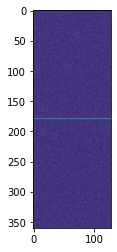

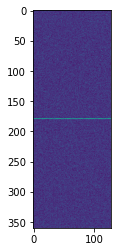

In [66]:
img = read_file('hb_test_sqrt_line_2.h5')
%matplotlib inline
plt.imshow(img[0])
plt.pause(0.1)
plt.imshow(img[1])

In [ ]:
%debug

In [89]:
res = [pd.read_csv(fn) for fn in list(Path('../data/custom_data/DATA_V11/pos').glob('*.csv'))]
res = pd.concat(res, ignore_index=True)

In [90]:
res.shape

(3989, 9)